In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

from torch import nn
from dataclasses import dataclass
from typing import Any, List, Sequence, Tuple
from telesketch.envs.discrete_telesketch import DiscreteTelesketchEnv
from tqdm.notebook import tqdm, trange
from rllib.utils.plots import *

import gymnasium as gym
import torch.distributions as tp
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
from IPython import display


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPS = np.finfo(np.float32).eps.item()

In [4]:
m2s = lambda m, s: m(torch.rand(s).to(DEVICE)).size()

In [5]:
class PicassoModel2(nn.Module):
    def __init__(self, env) -> None:
        super(PicassoModel2, self).__init__()
        
        # Global model
        self.dmap_model = nn.Sequential(
            nn.Conv2d(1, 32, 8, 4),
            nn.Mish(),
            nn.Conv2d(32, 64, 4, 2),
            nn.Mish(),
            nn.Conv2d(64, 64, 3),
            nn.Flatten()
        )

        # Global model
        self.gref_model = nn.Sequential(
            nn.Conv2d(1, 32, 8, 4),
            nn.Mish(),
            nn.Conv2d(32, 64, 4, 2),
            nn.Mish(),
            nn.Conv2d(64, 64, 3),
            nn.Flatten()
        )

        # Global model
        self.gcnv_model = nn.Sequential(
            nn.Conv2d(1, 32, 8, 4),
            nn.Mish(),
            nn.Conv2d(32, 64, 4, 2),
            nn.Mish(),
            nn.Conv2d(64, 64, 3),
            nn.Flatten()
        )

        # Local model
        self.lref_model = nn.Sequential(
            nn.Conv2d(1, 64, 8),
            nn.Mish(),
            nn.Flatten()
        )

        self.lcnv_model = nn.Sequential(
            nn.Conv2d(1, 64, 8),
            nn.Mish(),
            nn.Flatten()
        )

        # Infer output size for FCL
        sample_state, _ = env.reset()
        gs = (1, 1) + sample_state["ref"].shape
        ls = (1, 1) + sample_state["ref_patch"].shape

        output_size = m2s(self.gref_model, gs)[1] * 3 + m2s(self.lref_model, ls)[1] * 2

        self.linear_model = nn.Sequential(
            nn.Linear(output_size, 9),
        ).to(DEVICE)


    def forward(self, state):
        # Add extra dimension for batch
        gref = torch.from_numpy(state["ref"]).unsqueeze(0).unsqueeze(0).to(DEVICE)
        gcnv = torch.from_numpy(state["cnv"]).unsqueeze(0).unsqueeze(0).to(DEVICE)
        dmap = torch.from_numpy(state["loc"]).unsqueeze(0).unsqueeze(0).to(DEVICE)

        lref = torch.from_numpy(state["ref_patch"]).unsqueeze(0).unsqueeze(0).to(DEVICE)
        lcnv = torch.from_numpy(state["cnv_patch"]).unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Concatenate layers outputs
        X = torch.cat([
            self.gref_model(gref),
            self.gcnv_model(gcnv),
            self.dmap_model(dmap),
            self.lref_model(lref),
            self.lcnv_model(lcnv)
        ], dim=1)

        output = self.linear_model(X).squeeze()

        # Make categorical distribution
        dist = tp.Categorical(logits=output[:-1])
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action, log_prob, output[-1]


In [6]:
class PicassoModel(nn.Module):
    def __init__(self, env) -> None:
        super(PicassoModel, self).__init__()
        
        # Global model
        self.global_model = nn.Sequential(
            nn.Conv2d(3, 32, 8, 4),
            nn.Mish(),
            nn.Conv2d(32, 64, 8, 2),
            nn.Mish(),
            nn.Conv2d(64, 64, 3),
            nn.Flatten()
        ).to(DEVICE)

        # Local model
        self.local_model = nn.Sequential(
            nn.Conv2d(2, 64, 4),
            nn.Mish(),
            nn.Flatten()
        ).to(DEVICE)

        # Infer output size for FCL
        sample_state, _ = env.reset()
        gs = (1, 3) + sample_state["ref"].shape
        ls = (1, 2) + sample_state["ref_patch"].shape

        output_size = m2s(self.global_model, gs)[1] + m2s(self.local_model, ls)[1]

        # FCL model
        self.linear_model = nn.Sequential(
            nn.ReLU(),
            nn.Linear(output_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 9)
        ).to(DEVICE)

        

    def forward(self, state):
        # Stack inputs as channels
        with torch.no_grad():
            global_input_np = np.stack([state["ref"], state["cnv"], state["loc"]])
            local_input_np = np.stack([state["ref_patch"], state["cnv_patch"]])

            # Add extra dimension for batch
            global_input = torch.from_numpy(global_input_np).unsqueeze(0).to(DEVICE)
            local_input = torch.from_numpy(local_input_np).unsqueeze(0).to(DEVICE)

        # Concatenate layers outputs
        X = torch.cat([
            self.global_model(global_input),
            self.local_model(local_input)
        ], dim=1)

        output = self.linear_model(X).squeeze()

        # Make categorical distribution
        dist = tp.Categorical(logits=output[:-1])
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action, log_prob, output[-1]


In [126]:
class PicassoSimple(nn.Module):
    def __init__(self, env) -> None:
        super(PicassoModel, self).__init__()
        
        # Global model
        self.global_model = nn.Sequential(
           #nn.Conv2d(3, 32, 16, 2),
            nn.Conv2d(3, 32, 8, 4),
            nn.Mish(),
            nn.Conv2d(32, 64, 8, 2),
            nn.Mish(),
            nn.Conv2d(64, 64, 3),
            nn.Flatten()
        ).to(DEVICE)

        # Local model
        # self.local_model = nn.Sequential(
        #     nn.Conv2d(2, 64, 4),
        #     nn.Mish(),
        #     nn.Flatten()
        # ).to(DEVICE)

        # Infer output size for FCL
        sample_state, _ = env.reset()
        gs = (1, 3) + sample_state["ref"].shape
        # ls = (1, 2) + sample_state["ref_patch"].shape

        output_size = m2s(self.global_model, gs)[1] #+ m2s(self.local_model, ls)[1]

        # FCL model
        self.linear_model = nn.Sequential(
            nn.ReLU(),
            nn.Linear(output_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 9)
        ).to(DEVICE)

        

    def forward(self, state):
        # Stack inputs as channels
        with torch.no_grad():
            global_input_np = np.stack([state["ref"], state["cnv"], state["loc"]])
            local_input_np = np.stack([state["ref_patch"], state["cnv_patch"]])

            # Add extra dimension for batch
            global_input = torch.from_numpy(global_input_np).unsqueeze(0).to(DEVICE)
            local_input = torch.from_numpy(local_input_np).unsqueeze(0).to(DEVICE)

        # Concatenate layers outputs
        X = self.global_model(global_input)
        # X = torch.cat([
        #     self.global_model(global_input),
        #     self.local_model(local_input)
        # ], dim=1)

        output = self.linear_model(X).squeeze()

        # Make categorical distribution
        dist = tp.Categorical(logits=output[:-1])
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action, log_prob, output[-1]


In [127]:
def compute_returns(r: torch.FloatTensor, gamma: float) -> torch.FloatTensor:
    """Computes the returns for a given gamma for episodic A2C

    Args:
        r (torch.FloatTensor): rewards
        gamma (float): gamma value

    Returns:
        torch.FloatTensor: returns
    """
    # Aux vars
    t = torch.arange(0, r.size(dim=0)).to(DEVICE)

    # Compute factors
    delta = r * gamma ** t
    g = torch.flip(torch.cumsum(torch.flip(delta, (0,)), 0), (0,)) / gamma ** t

    # Return expected returns
    return g

In [128]:
HUBER_LOSS = torch.nn.HuberLoss(reduction="mean")

def compute_loss(log_probs: torch.FloatTensor, 
                 values: torch.FloatTensor, 
                 returns: torch.FloatTensor, 
                 critic_weight=1, 
                 entropy_weight=0) -> torch.FloatTensor:
    
    """Computes the loss for A2C

    Returns:
        torch.Tensor: loss value
    """

    # Compute advantage
    adv = returns - values

    # Actor loss
    actor_loss = -(log_probs * adv.detach()).mean()

    # Entropy loss
    entropy_loss = -(log_probs * torch.exp(log_probs)).mean() * entropy_weight

    # Critic loss
    critic_loss = HUBER_LOSS(values, returns) * critic_weight

    return actor_loss, critic_loss, entropy_loss

In [129]:
@dataclass
class A2C:
    # Mandatory arguments
    env: gym.Env
    model: nn.Module
    optimizer: optim.Optimizer

    # Default parameters
    gamma: float = 0.99
    critic_weight: float = 1
    entropy_weight: float = 0
    max_steps: float = 500

    def run_episode(self, init_state) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Runs an episode up until its done or `max_step` are completed

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]: Returns three tensors
            representing the log_prob, rewards and values respectively
        """

        # Get states to tensort
        state = init_state

        # Transitions stack
        transitions = []

        for n_step in range(self.max_steps):
            # Pick an action
            action, log_prob, value = self.model(state)

            # Perform step
            state, reward, done, _ = self.env.step(action.detach().item())

            # Save transition results
            transitions += [(log_prob, torch.tensor(reward, device=DEVICE).float(), value)]


            # Bail out if we're done
            if done: break
        
        return [torch.stack(x) for x in zip(*transitions)]
    
    def train(self, log_probs, rewards, values):
        # Compute returns
        returns = compute_returns(rewards, self.gamma)
        
        # Compute loss
        actor_loss, critic_loss, entropy_loss = compute_loss(log_probs, values, returns, self.critic_weight, self.entropy_weight)

        # Compute total loss
        loss = actor_loss + critic_loss - entropy_loss

        # Backpropagate and update gradients
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return torch.sum(rewards), actor_loss, critic_loss, entropy_loss

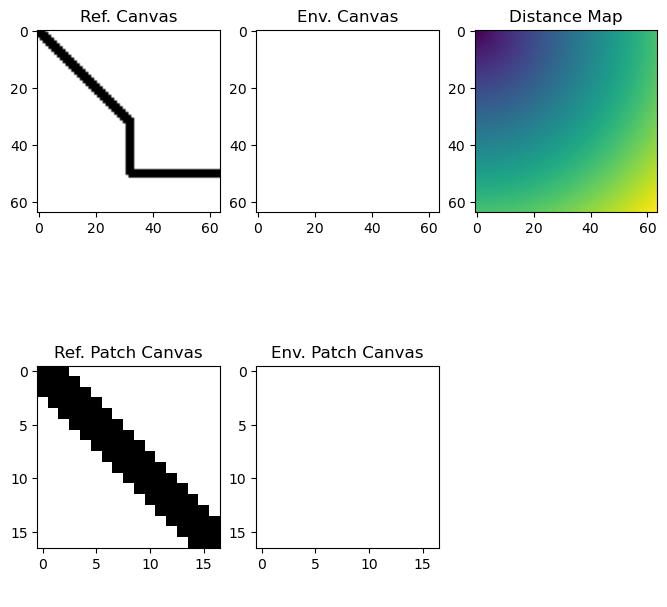

In [150]:
from skimage.metrics import normalized_root_mse

# Ref canvas
IMG_SIZE = 64
PATCH_SIZE = 17
ref_canvas = np.full((IMG_SIZE, IMG_SIZE, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (32, 32), (0, 0, 0), 2)
ref_canvas = cv2.line(ref_canvas, (32, 32), (32, 50), (0, 0, 0), 2)
ref_canvas = cv2.line(ref_canvas, (32, 50), (64, 50), (0, 0, 0), 2)

rmse = lambda x, y: np.sum((x - y) ** 2)
hu2 = lambda x, y: np.array([cv2.matchShapes(x, y, cv2.CONTOURS_MATCH_I2, 0)])
nrmse = lambda x, y: normalized_root_mse(x, y)

env = DiscreteTelesketchEnv(ref_canvas, 
                            rmse,
                            lambda x, y: nrmse(x, y) < 0.15,
                            5, 2, 
                            patch_size=(PATCH_SIZE, PATCH_SIZE), 
                            render_mode="image"
)

env.reset()
env.render()

In [151]:
# CONSTANTS
N_EPISODES = 10000
MAX_STEPS = 500
GAMMA = 0.6

# Define model and optimizer
model = PicassoModel(env).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

# Define agent
agent = A2C(env, model, optimizer, max_steps=MAX_STEPS, gamma=GAMMA, entropy_weight=0.8)


In [152]:
torch.cuda.empty_cache()
#fig.show()

# Get display handle
#display.display(fig, display_id=True)

# Start training
reward_log = []
actor_loss_log = []
critic_loss_log = []
entropy_loss_log = []


try:
    
    for e in (tbar := trange(N_EPISODES)):
        # Reset environment
        init_state, _ = agent.env.reset()
        
        # Get variables
        log_probs, rewards, values = agent.run_episode(init_state)

        # Train model
        reward, actor_loss, critic_loss, entropy_loss = agent.train(log_probs, rewards, values)
        
        # Save info
        reward_log.append(reward.item())
        actor_loss_log.append(actor_loss.item()), 
        critic_loss_log.append(critic_loss.item()), 
        entropy_loss_log.append(entropy_loss.item())
        
        # Update progressbar
        tbar.set_postfix(
            reward=reward.item(), 
            actor_loss=actor_loss.item(), 
            critic_loss=critic_loss.item(), 
            entropy_loss=entropy_loss.item()
        )
        
except KeyboardInterrupt:
    print("Training stopped...")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [138]:
# Prepare figures
fig = make_live_plot("Rewards")


# Update plot
update_live_plot(fig, reward_log)

fig

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Rewards',
              'type': 'scatter'…

In [139]:
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import *
import cv2 as cv

class Player:
    def __init__(self, model, env):
        self.model = model
        self.env = env
    
    def reset(self):
        self.state, _ = self.env.reset()
    
    def step(self):
        # Pick an action
        action, _, _ = self.model(self.state)
        
        # Perform action
        step_output = self.env.step(action.item())
        self.state = step_output[0]

        # Get images
        ref = self.state["ref"]
        cnv = self.state["cnv"]

        return (
            step_output[1], 
            step_output[3]["sim"],
            nrmse(ref, cnv),
            step_output[2]
        )
    
    def run(self, steps, render=False):
        r, sim, ermse, done = map(np.array, zip(*[self.step() for _ in range(steps)]))

        if render:
            fig, ax = plt.subplots(1, 3, figsize=(30, 8))
            step_done = np.where(done == True)[0]

            ax[0].plot(r)
            ax[1].plot(sim)
            ax[2].plot(ermse)

            if step_done.size > 0:
                ax[0].axvline(step_done[0], color="r")
                ax[1].axvline(step_done[0], color="r")
                ax[2].axvline(step_done[0], color="r")

            ax[0].set_title("Rewards")
            ax[1].set_title("Similarity Function")
            ax[2].set_title("N. Similarity Function")

            plt.show()
        
        if render:
            return

        return r, sim, done
  
    
    def render(self):
        self.env.render()


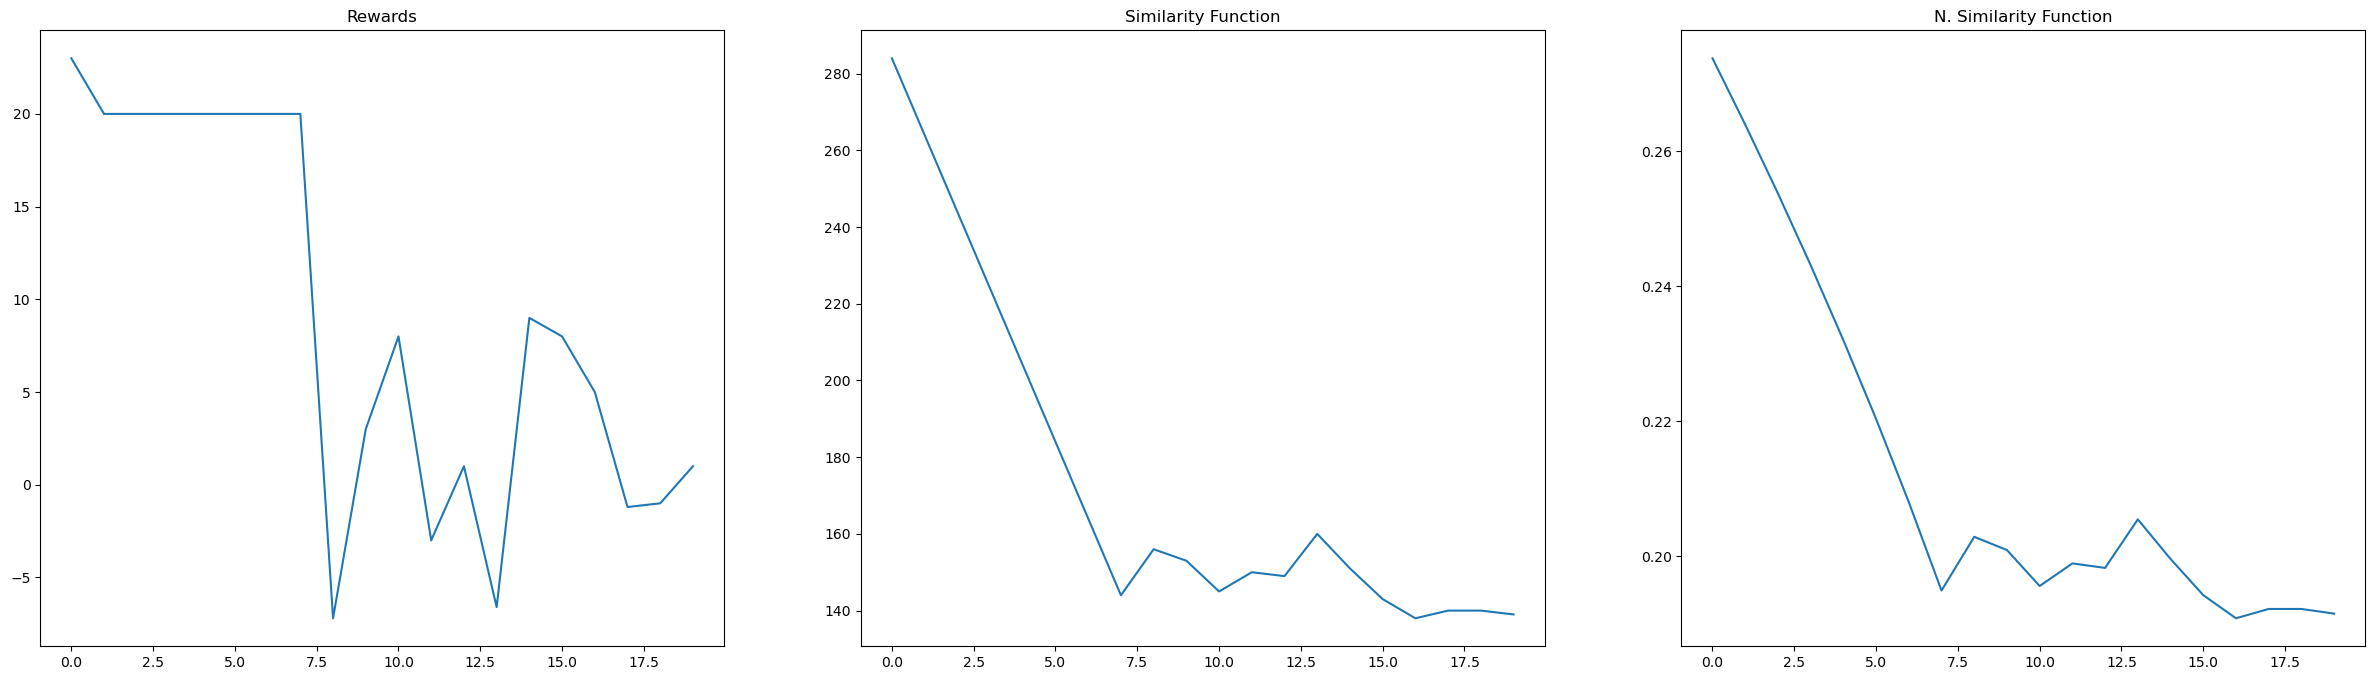

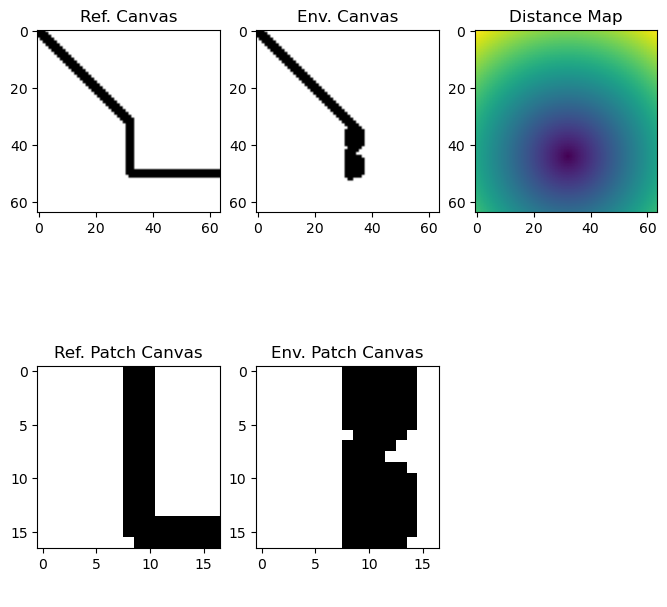

In [148]:
player = Player(model, env)

player.reset()
player.run(20, True)
player.render()

In [17]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import hausdorff_distance

state = player.env._get_obs()

# Get out images
ref = state["ref"]
cnv = state["cnv"]


print(ssim(ref, cnv, data_range=1))
print(hausdorff_distance(ref, cnv, method="modified"))

0.8885638201990989
0.05259599006425781


In [18]:

cnv.astype(bool)

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])